Dataset: [kaggle/CarDekho](https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv)

## 1. Importing libraries

In [1]:
import imp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
from datetime import date
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor

import pickle

## 2. Data Inspection

In [ ]:
%cd ~/codes/car_price/data
%ll

/home/groot/codes/car_price/data
total 2496
-rw-r--r-- 1 groot   17209 Aug 20 13:05 'car data.csv'
-rw-r--r-- 1 groot  354635 Aug 20 13:05 'CAR DETAILS FROM CAR DEKHO.csv'
-rw-r--r-- 1 groot 1041637 Aug 20 13:05 'Car details v3.csv'
-rw-r--r-- 1 groot 1132298 Aug 20 13:05  Cleaned_car_data.csv


In [ ]:
data1 = pd.read_csv('car data.csv')
data2 = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')
data3 = pd.read_csv('Car details v3.csv')

In [ ]:
print(f'data1: {data1.shape}')
print(f'data2: {data2.shape}')
print(f'data3: {data3.shape}')

data1: (301, 9)
data2: (4340, 8)
data3: (8128, 13)


__We will use data3, data2 for training__
### Merging data2 and data3

We will use only comman features present in both datasets

In [ ]:
data2col = set(data2.columns.values)
data3col = set(data3.columns.values)

print(f'data2 columns: {data2col}')
print(f'data3 columns: {data3col}')
print(f"Comman columns: {data2col & data3col}")

data2 columns: {'selling_price', 'owner', 'transmission', 'name', 'year', 'km_driven', 'seller_type', 'fuel'}
data3 columns: {'max_power', 'selling_price', 'seats', 'owner', 'transmission', 'name', 'year', 'mileage', 'engine', 'km_driven', 'torque', 'seller_type', 'fuel'}
Comman columns: {'selling_price', 'owner', 'transmission', 'name', 'year', 'km_driven', 'seller_type', 'fuel'}


In [ ]:
# merging both datasets on comman column 
data = data2.append(data3[list(data2col & data3col)])
data.reset_index(drop=True)

/tmp/ipykernel_5397/1853342337.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data2.append(data3[list(data2col & data3col)])


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
12463,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner
12464,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner
12465,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner
12466,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner


In [ ]:
# now we have total rows
data.shape[0]

12468

__Checking null values__

In [ ]:
data.isnull().sum()/data.shape[0]*100

name             0.0
year             0.0
selling_price    0.0
km_driven        0.0
fuel             0.0
seller_type      0.0
transmission     0.0
owner            0.0
dtype: float64

looking at above results, we have __0% Null values__ in our dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12468 entries, 0 to 8127
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           12468 non-null  object
 1   year           12468 non-null  int64 
 2   selling_price  12468 non-null  int64 
 3   km_driven      12468 non-null  int64 
 4   fuel           12468 non-null  object
 5   seller_type    12468 non-null  object
 6   transmission   12468 non-null  object
 7   owner          12468 non-null  object
dtypes: int64(3), object(5)
memory usage: 876.7+ KB


In [ ]:
data.describe()

,year,selling_price,km_driven
count,12468.000000,1.246800e+04,1.246800e+04
mean,2013.555743,5.915773e+05,6.856508e+04
std,4.118485,7.377876e+05,5.333721e+04
min,1983.000000,2.000000e+04,1.000000e+00
25%,2011.000000,2.400000e+05,3.500000e+04
50%,2014.000000,4.200000e+05,6.000000e+04
75%,2017.000000,6.500000e+05,9.000000e+04
max,2020.000000,1.000000e+07,2.360457e+06


* __Dataset have more Categorical features__
* __We can change year column for make it informative__
* __dataset have no null values__
* __dataset may have outliers as observing `km_driven` field have minimum values as 1__
* __Each car name contain company name which can be seperate useful feature__ 

## 3. Data preprocessing

__We have 'year' column, using which we can calculate Age of car which will make more sense__

In [ ]:
data['age'] = date.today().year - data['year']
data.drop(columns=['year'], inplace=True)

__We will extract company name from car name__ 

In [ ]:
data['company'] = data['name'].str.extract(r"^(\w+)")
data.sample(5)

,name,selling_price,km_driven,fuel,seller_type,transmission,owner,age,company
292,Hyundai i10 Sportz AT,290000,50000,Petrol,Individual,Automatic,First Owner,9,Hyundai
1666,Maruti Swift Dzire 1.2 Vxi BSIV,368000,90000,Petrol,Individual,Manual,Second Owner,10,Maruti
7356,Volkswagen Vento Diesel Highline,240000,110000,Diesel,Individual,Manual,First Owner,11,Volkswagen
2312,Maruti Wagon R CNG LXI,270000,80000,CNG,Individual,Manual,Second Owner,9,Maruti
3068,Maruti Swift Dzire LDI,455000,60000,Diesel,Individual,Manual,First Owner,5,Maruti


In [ ]:
#%cd ~/codes/car_price/data
data.to_csv('Cleaned_car_data.csv') # saved cleaned data file

In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/MyDrive/Colab Notebooks/Datasets 
# data = pd.read_csv('Cleaned_car_data.csv')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks/Datasets


## 4. EDA
Lets do Analysis of data

In [3]:
data.head()

,Unnamed: 0,name,selling_price,km_driven,fuel,seller_type,transmission,owner,age,company
0,0,Maruti 800 AC,60000,70000,Petrol,Individual,Manual,First Owner,15,Maruti
1,1,Maruti Wagon R LXI Minor,135000,50000,Petrol,Individual,Manual,First Owner,15,Maruti
2,2,Hyundai Verna 1.6 SX,600000,100000,Diesel,Individual,Manual,First Owner,10,Hyundai
3,3,Datsun RediGO T Option,250000,46000,Petrol,Individual,Manual,First Owner,5,Datsun
4,4,Honda Amaze VX i-DTEC,450000,141000,Diesel,Individual,Manual,Second Owner,8,Honda


### Categorical features analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count of Cars')

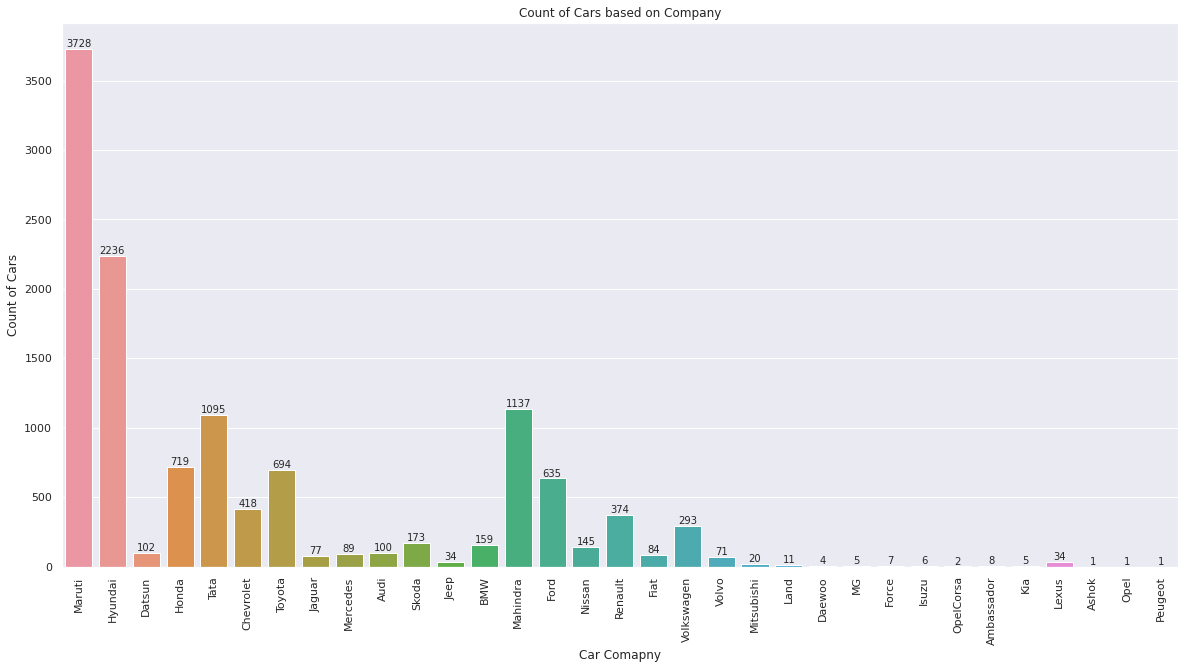

In [4]:
plt.figure(figsize=[20,10])
plot = sns.countplot('company', data=data)
plt.xticks(rotation=90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')
plt.title("Count of Cars based on Company");
plt.xlabel('Car Comapny')
plt.ylabel('Count of Cars')

Text(0.5, 1.0, 'Price vs Company')

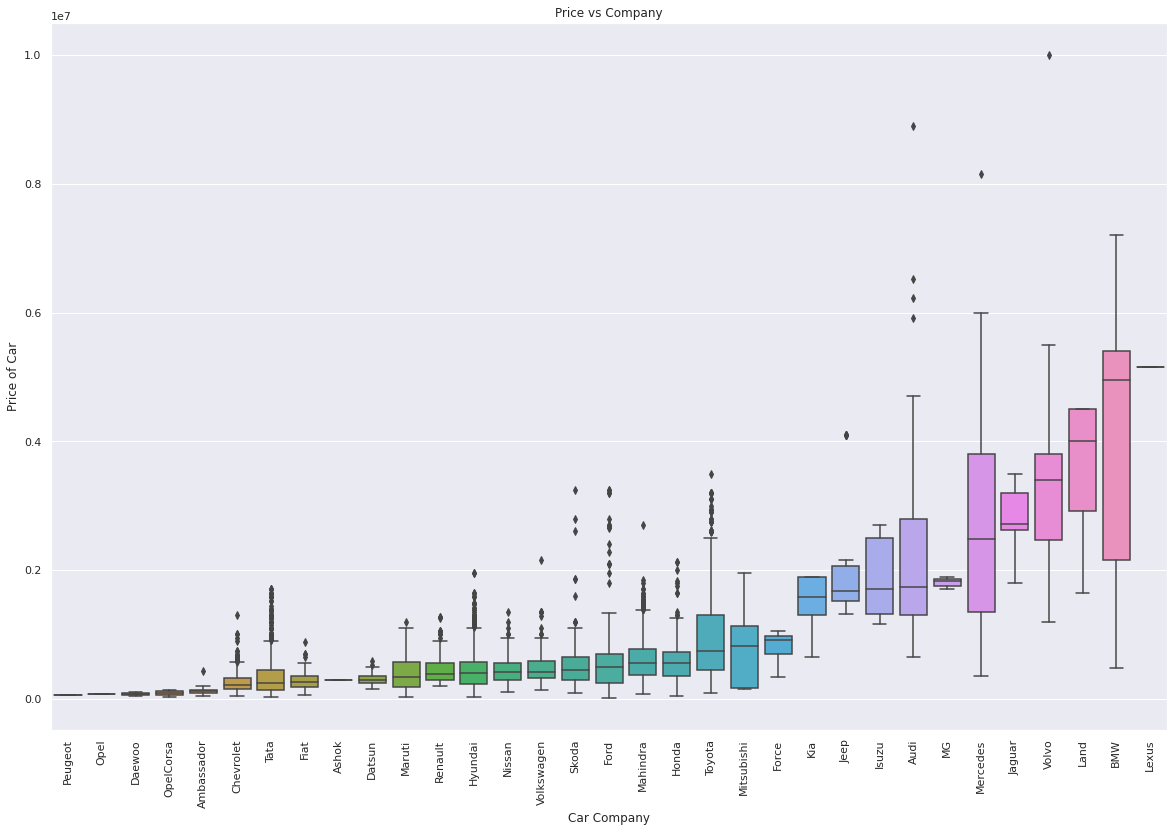

In [5]:
plt.figure(figsize=[20,13])
sorted_nb = data.groupby(['company'])['selling_price'].median().sort_values()
sns.boxplot(x=data['company'], y=data['selling_price'], order=list(sorted_nb.index))
plt.xticks(rotation=90)
plt.ylabel('Price of Car')
plt.xlabel('Car Company')
plt.title('Price vs Company')

* Maximum cars in the dataset are by the manufacturer Maruti and there are no null values.
* Even though Maruti have high numbers in count, price of cars not very high.

In [6]:
Categorical_col = ['fuel','seller_type','transmission','owner']
#palett = ['flag','spring','twilight','summer']

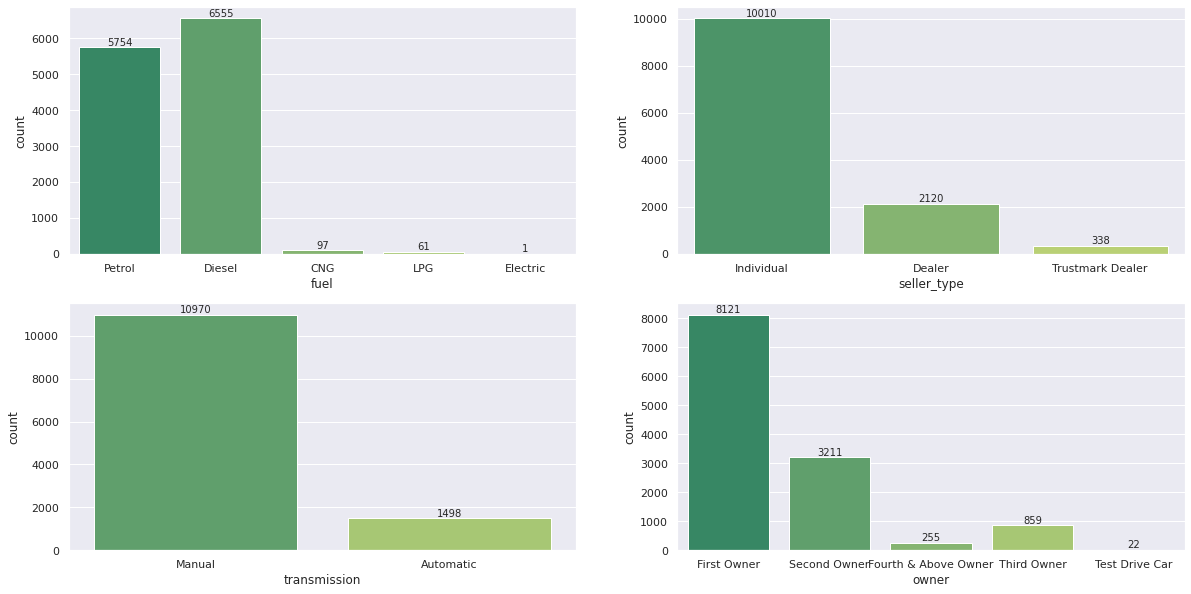

In [7]:
plt.figure(figsize=[20,10])
for i,col in enumerate(Categorical_col):
    plt.subplot(2,2,i+1)
    plot = sns.countplot(x=data[col], palette='summer')
    for p in plot.patches:
        plot.annotate(p.get_height(), 
                            (p.get_x() + p.get_width() / 2.0, 
                            p.get_height()), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')
    #plt.title(f'Count of Cars wrt {col}')

* __we have very less amount of data for CNG, LPG and Electric cars, specially Electric we have only 1 car__
* __People preferring Individual seller over other__
* __People prefer manual cars over automatic__
* __Test drive cars are not prefered by people__

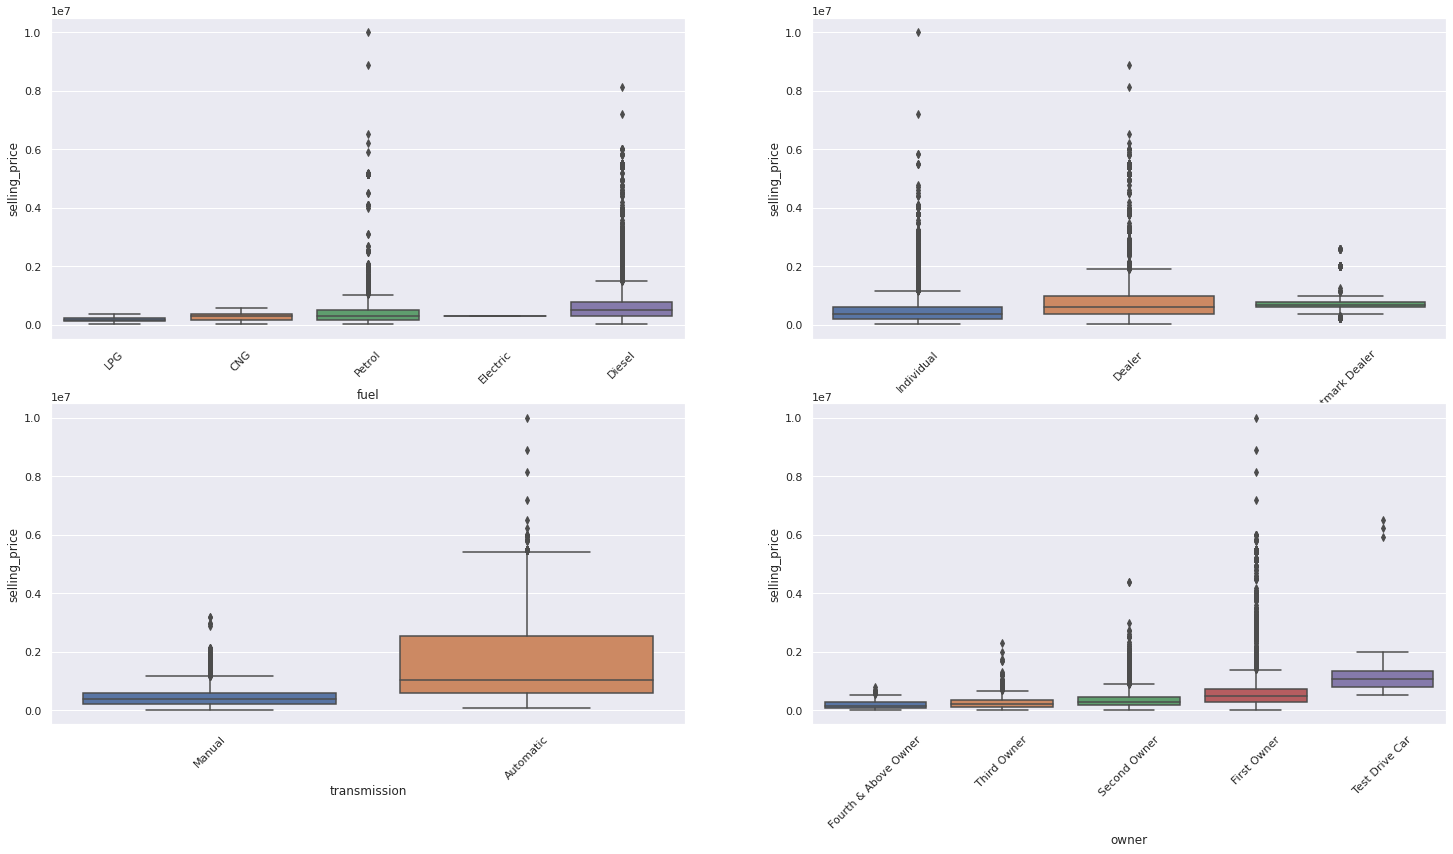

In [8]:
plt.figure(figsize=[25,13])
for i,col in enumerate(Categorical_col):
    plt.subplot(2,2,i+1)
    sorted_nb = data.groupby([col])['selling_price'].median().sort_values()
    sns.boxplot(x=data[col], y=data['selling_price'], order=list(sorted_nb.index))
    plt.xticks(rotation=45);

* __Petrol and Diesel cars price between same range__
* __Automatic car price ranges high__
* __First owner car price ranges high compare to other__

### Numerical features Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


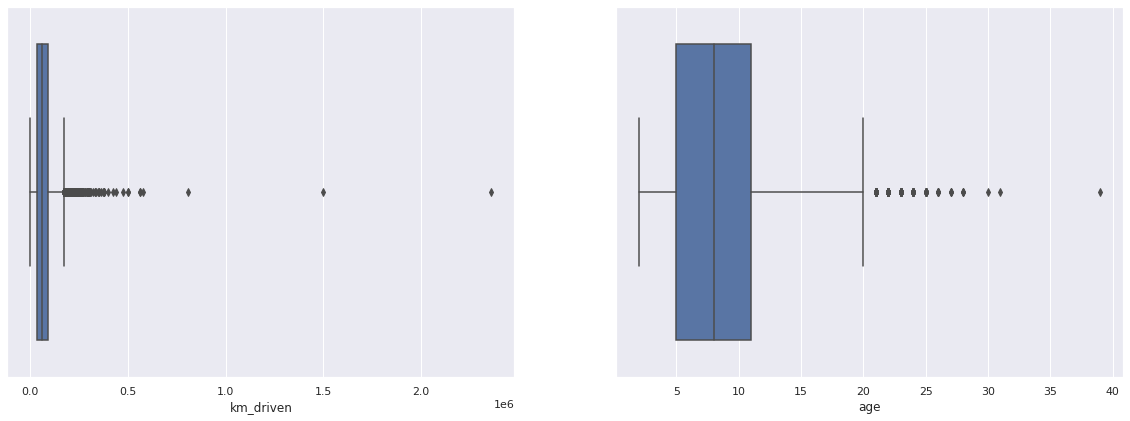

In [9]:
num_cols = ['km_driven', 'age']
fig = plt.figure(figsize=[20,15])

for i in range(2):
    plt.subplot(2,2,i+1)
    sns.boxplot(data[num_cols[i]])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


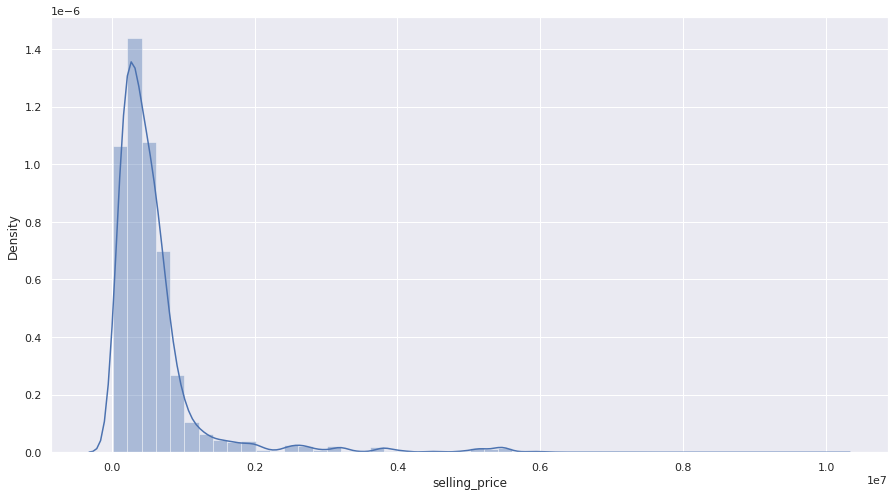

In [10]:
plt.figure(figsize=[15,8])
sns.distplot(data['selling_price'])

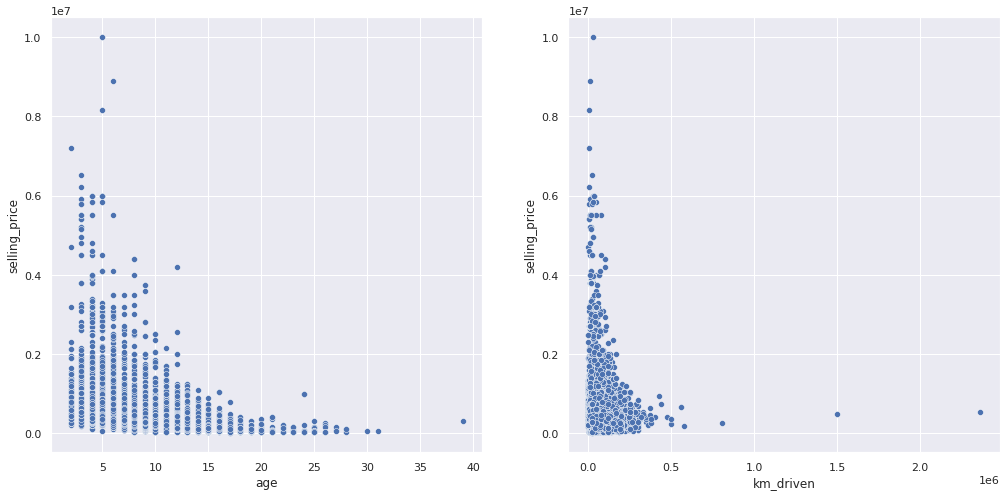

In [11]:
fig = plt.figure(figsize=[17,8])
plt.subplot(1,2,1)
sns.scatterplot(x='age',y='selling_price',data=data)
plt.subplot(1,2,2)
sns.scatterplot(x='km_driven',y='selling_price',data=data)
plt.show()

__from above observations :__
* some outliers present in our dataset
* `selling_price` have some outliers
* all numerical features contain some outliers
* both age and km_driven are inversely propositional to price

Conclusion :<br>
__We will remove outliers and we will remove Eletric car data as it is very very less__

In [12]:
len(data[data['selling_price']>data['selling_price'].quantile(0.99)])

120

In [13]:
len(data[data['km_driven']>data['km_driven'].quantile(0.99)])

125

In [14]:
len(data[data['age']>data['age'].quantile(0.99)])

112

In [15]:
# removing outliers
data_new = data.copy()
data_new = data_new[
                (data_new['selling_price']<data_new['selling_price'].quantile(0.99))&
                (data_new['km_driven']<data_new['km_driven'].quantile(0.99))&
                (data_new['age']<data_new['age'].quantile(0.99))
                ]
print(f'Rows removed: {data.shape[0]-data_new.shape[0]}')

Rows removed: 395


In [16]:
# remove electric vehicle data
data_new = data_new[~(data_new['fuel']=='Electric')]

#### Correlations

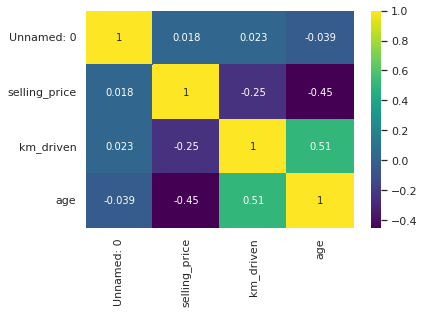

In [17]:
sns.heatmap(data_new.corr(), annot=True, cmap="viridis")
plt.show()

In [18]:
data_new.corr()['selling_price']

Unnamed: 0       0.018065
selling_price    1.000000
km_driven       -0.246759
age             -0.454124
Name: selling_price, dtype: float64

In [19]:
#data_new = data_new[(data_new['owner']!='Test Drive Car')&(data['fuel']!='Electric')]

* __Removed Test drive and Electric car data as very less number of data__

In [20]:
data_new_ = pd.get_dummies(data_new,columns=['fuel','transmission','seller_type','owner','company'],drop_first=True)

In [21]:
data_new_.head()

,Unnamed: 0,name,selling_price,km_driven,age,fuel_Diesel,fuel_LPG,fuel_Petrol,transmission_Manual,seller_type_Individual,...,company_Mercedes,company_Mitsubishi,company_Nissan,company_OpelCorsa,company_Renault,company_Skoda,company_Tata,company_Toyota,company_Volkswagen,company_Volvo
0,0,Maruti 800 AC,60000,70000,15,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Maruti Wagon R LXI Minor,135000,50000,15,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,2,Hyundai Verna 1.6 SX,600000,100000,10,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,3,Datsun RediGO T Option,250000,46000,5,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4,Honda Amaze VX i-DTEC,450000,141000,8,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


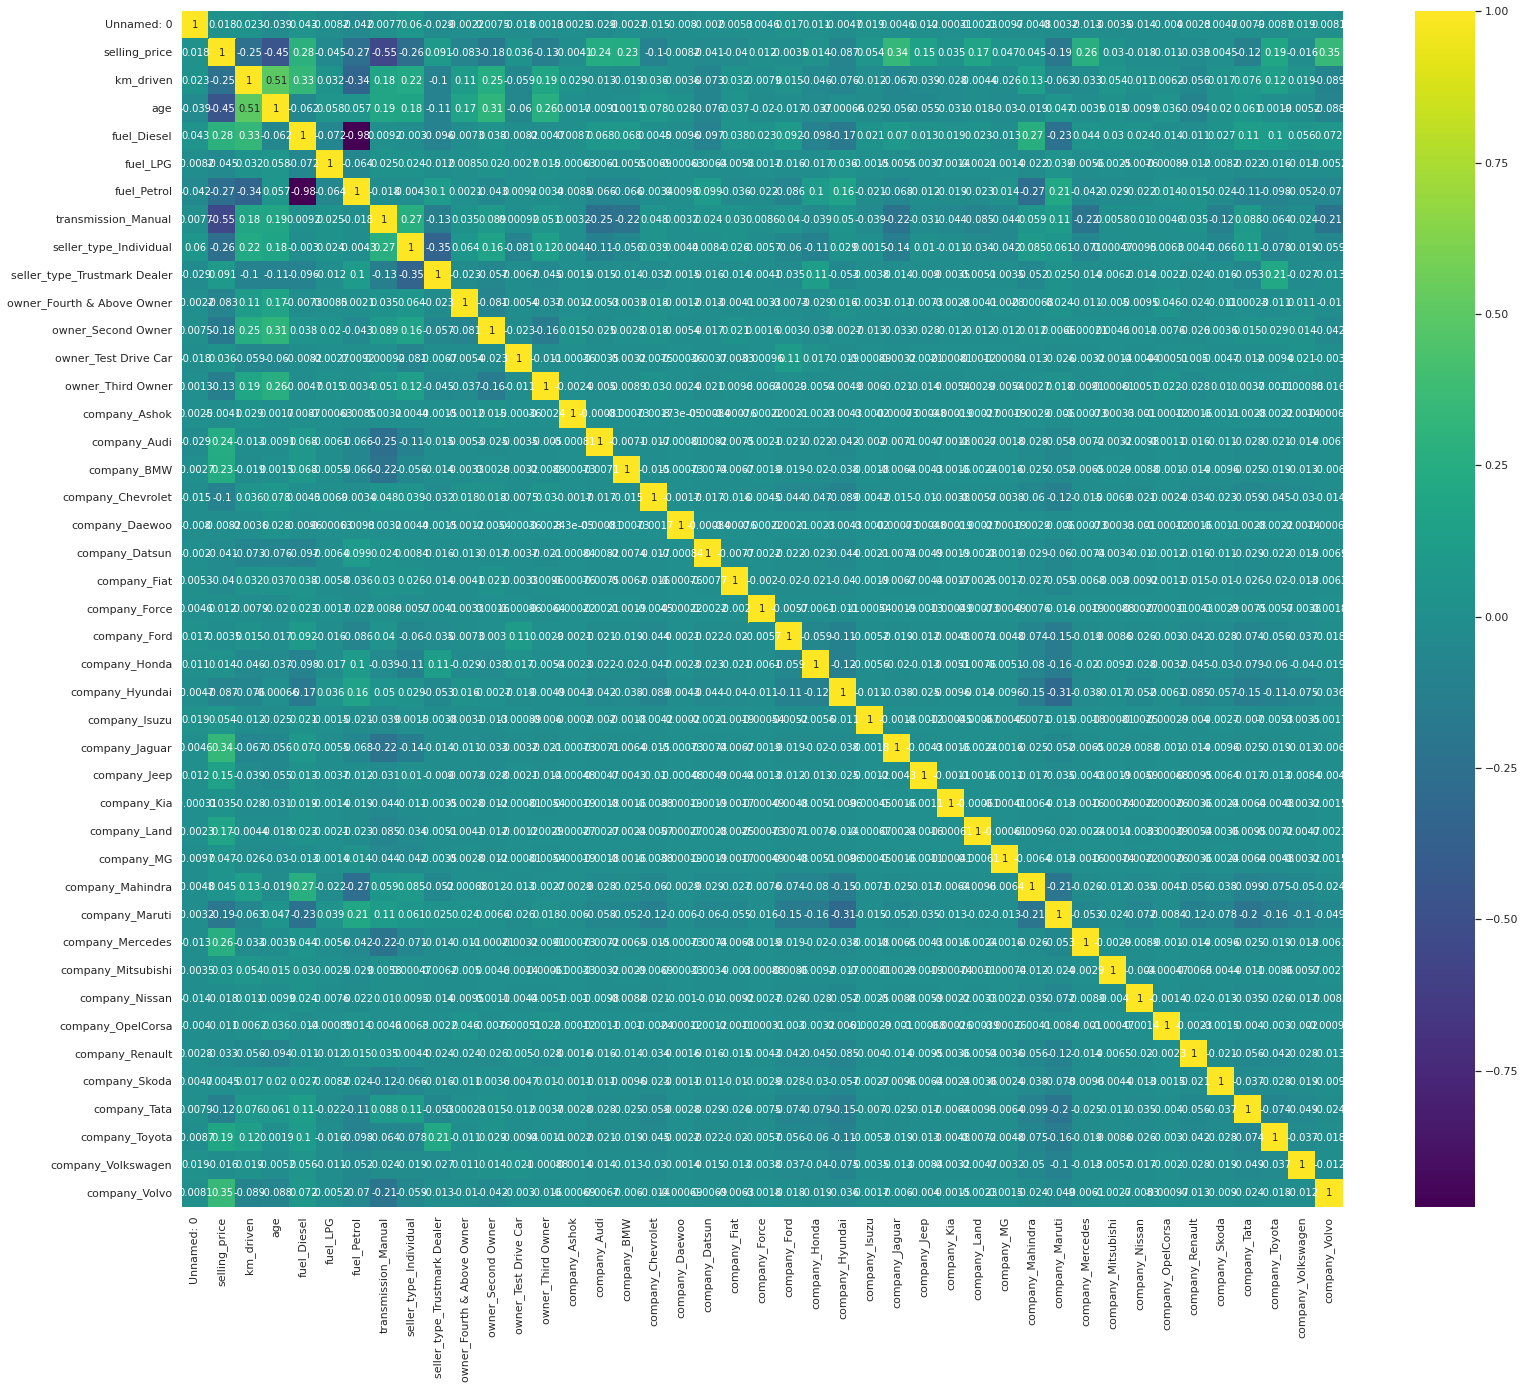

In [22]:
correlation = data_new_.corr()
plt.figure(figsize=[26,22])
sns.heatmap(correlation, annot=True, cmap="viridis")

In [23]:
# thanks to: https://www.kaggle.com/code/koustavghosh149/simple-approach-to-house-price-prediction-dataset
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [24]:
correlation(data_new_, 0.7)

{'fuel_Petrol'}

* __fuel_diesel__ and __fuel_petrol__ features are highly correlated. We will use __fuel_diesel__ only

In [25]:
data_new_.drop(columns=['fuel_Petrol'], inplace=True)

#### Final Changes
We have to drop `name` column.

In [26]:
data_new_.drop(columns=['name'], inplace=True)
data_new_.head()

,Unnamed: 0,selling_price,km_driven,age,fuel_Diesel,fuel_LPG,transmission_Manual,seller_type_Individual,seller_type_Trustmark Dealer,owner_Fourth & Above Owner,...,company_Mercedes,company_Mitsubishi,company_Nissan,company_OpelCorsa,company_Renault,company_Skoda,company_Tata,company_Toyota,company_Volkswagen,company_Volvo
0,0,60000,70000,15,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,135000,50000,15,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,600000,100000,10,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,250000,46000,5,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,450000,141000,8,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## 6. Model

In [ ]:
X = data_new_.drop(columns=['selling_price'])
y = data_new['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

## Machine Learning

In [ ]:
# THANKS TO https://github.com/prateeknigam9/Hinglish_Classifier/blob/main/CaseStudy_Hinglish.ipynb

def metric_calc(model, xtrain, ytrain, xtest, ytest):
    """
    To plot the metrics and graph of regression
    ==============================================
    inputs:
      model: Model selected
      xtrain: input for train
      ytrain: ground truth for xtrain
      xtest: input for test
      ytest: ground truth for xtest
    outputs:
      PRINT --> Metrics R2_score, MAE, MSE, RMSE for both Train and validation
      RETURN --> Metrics for Validation

    """
    y_pred_train = model.predict(xtrain)
    r2_train = r2_score(ytrain,y_pred_train)
    mae_train = mean_absolute_error(ytrain,y_pred_train)
    mse_train = mean_squared_error(ytrain,y_pred_train)
    rmse_train = np.sqrt(mse_train)    
    
    metrics_train = {}
    metrics_train['R2_Score'] = r2_train
    metrics_train['MAE'] = mae_train
    metrics_train['MSE'] = mse_train
    metrics_train['RMSE'] = rmse_train
    
    y_pred = model.predict(xtest)
    r2 = r2_score(ytest,y_pred)
    mae = mean_absolute_error(ytest,y_pred)
    mse = mean_squared_error(ytest, y_pred)
    rmse = np.sqrt(mse)
    
    metrics = {}
    metrics['R2_Score'] = r2
    metrics['MAE'] = mae
    metrics['MSE'] = mse
    metrics['RMSE'] = rmse

    print("="*20,"Model Metrics - Train","="*20)
    print(pd.DataFrame([metrics_train]))    
    print("\n")
    print("="*20,"Model Metrics - Test","="*20)
    print(pd.DataFrame([metrics]))
    
    return metrics

In [ ]:
# scaling data
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

#### 6.2 L1 and L2 regression

In [ ]:
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_scale, y_train)
lasso_model_metrics = metric_calc(lasso_model,X_train_scale,y_train,X_test_scale,y_test)

==================== Model Metrics - Train ====================
   R2_Score            MAE           MSE           RMSE
0   0.76081  167768.648497  7.047911e+10  265479.015369


==================== Model Metrics - Test ====================
   R2_Score            MAE           MSE          RMSE
0  0.739493  169698.667363  7.436268e+10  272695.20757


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.402e+14, tolerance: 2.846e+11
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [ ]:
ridge_model = Ridge(alpha=0.3)
ridge_model.fit(X_train_scale, y_train)

ridge_model_metrics = metric_calc(ridge_model,X_train_scale,y_train,X_test_scale,y_test)

==================== Model Metrics - Train ====================
   R2_Score            MAE           MSE           RMSE
0  0.760812  167762.403554  7.047878e+10  265478.406482


==================== Model Metrics - Test ====================
   R2_Score            MAE           MSE           RMSE
0  0.739492  169688.925765  7.436283e+10  272695.489492


#### 6.3 Support Vector Regressor

In [ ]:

svr_model = SVR(C=1.1,epsilon=0.001, kernel='linear')
svr_model.fit(X_train_scale, y_train)

svr_metrics = metric_calc(svr_model,X_train_scale,y_train,X_test_scale,y_test)

==================== Model Metrics - Train ====================
   R2_Score            MAE           MSE           RMSE
0 -0.021156  297356.867937  3.008916e+11  548535.913836


==================== Model Metrics - Test ====================
   R2_Score            MAE           MSE           RMSE
0 -0.024334  295016.748653  2.923994e+11  540739.716096


In [ ]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train_scale, y_train)
rfr_metric = metric_calc(rfr_model,X_train_scale,y_train,X_test_scale,y_test)

==================== Model Metrics - Train ====================
   R2_Score          MAE           MSE          RMSE
0   0.98085  43317.81635  5.642576e+09  75117.085011


==================== Model Metrics - Test ====================
   R2_Score          MAE           MSE           RMSE
0   0.85017  121807.6906  4.276935e+10  206807.512657


#### 6.4 AdaBoost Regressor

In [ ]:
ada_model = AdaBoostRegressor(base_estimator=RandomForestRegressor(),learning_rate=0.01, n_estimators=100)
ada_model.fit(X_train_scale, y_train)
ada_metrics = metric_calc(ada_model,X_train_scale,y_train,X_test_scale,y_test)

==================== Model Metrics - Train ====================
   R2_Score           MAE           MSE          RMSE
0   0.98441  42586.338389  4.593594e+09  67776.055776


==================== Model Metrics - Test ====================
   R2_Score            MAE           MSE           RMSE
0   0.85502  119791.850602  4.138505e+10  203433.154068


#### 6.5 GradientBoosting Regressor

In [ ]:
# gbdt = GradientBoostingRegressor()
# search_grid={'n_estimators':[100,500,1000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}
# search=GridSearchCV(estimator=gbdt,param_grid=search_grid,scoring='neg_mean_squared_error',cv=5)
# search.fit(X_train_scale, y_train)
# search.best_params_

In [ ]:
gbdt = GradientBoostingRegressor(learning_rate=0.01,max_depth=4,n_estimators=1000,random_state=1,subsample=0.5)
gbdt.fit(X_train_scale, y_train)

gbdt_metrics = metric_calc(gbdt,X_train_scale,y_train,X_test_scale,y_test)

==================== Model Metrics - Train ====================
   R2_Score           MAE           MSE          RMSE
0  0.887523  121167.22862  3.314219e+10  182049.95227


==================== Model Metrics - Test ====================
   R2_Score            MAE           MSE           RMSE
0  0.844946  131291.577729  4.426073e+10  210382.352914


#### 6.6. XGBoost Regressor

In [ ]:
xgb = XGBRegressor(n_estimators=1000, eta=0.01)

xgb.fit(X_train_scale, y_train)
xgb_metrics = metric_calc(xgb,X_train_scale,y_train,X_test_scale,y_test)

[11:28:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
==================== Model Metrics - Train ====================
   R2_Score            MAE           MSE           RMSE
0   0.91748  104706.420224  2.431532e+10  155933.701923


==================== Model Metrics - Test ====================
   R2_Score            MAE           MSE           RMSE
0  0.851906  125994.747846  4.227403e+10  205606.503469


In [ ]:
ML_comparison = pd.DataFrame([rfr_metric, lasso_model_metrics, ridge_model_metrics,svr_metrics,ada_metrics,gbdt_metrics,xgb_metrics],
                            index=['RandomForest','Lasso','Ridge','SVR','AdaBoost Reg','GBDT Reg','XGB Reg'])
ML_comparison.sort_values(by='RMSE')

,R2_Score,MAE,MSE,RMSE
AdaBoost Reg,0.855020,119791.850602,4.138505e+10,203433.154068
XGB Reg,0.851906,125994.747846,4.227403e+10,205606.503469
RandomForest,0.850170,121807.690600,4.276935e+10,206807.512657
GBDT Reg,0.844946,131291.577729,4.426073e+10,210382.352914
Lasso,0.739493,169698.667363,7.436268e+10,272695.207570
Ridge,0.739492,169688.925765,7.436283e+10,272695.489492
SVR,-0.024334,295016.748653,2.923994e+11,540739.716096


## Model Finalization:

In [27]:
X = data_new_.drop('selling_price',axis=1)
y = data_new_[['selling_price']]

#base_estimator=RandomForestRegressor(),learning_rate=0.01, n_estimators=100

In [28]:
# make pipeline
pipe = make_pipeline(StandardScaler(),XGBRegressor(n_estimators=1000, eta=0.01)
)
pipe.fit(X,y)

[13:51:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor', XGBRegressor(eta=0.01, n_estimators=1000))])

In [29]:
# save model as pickle file
with open('xgboost_model.pkl', 'wb') as files:
  pickle.dump(pipe, files)